In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('../../data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../../data/test_sessions.csv',
                      index_col='session_id')

# приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [5]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])

print(u'всего сайтов:', sites_dict_df.shape[0])

sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [6]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

sites = ['site%d' % i for i in range(1, 11)]

full_sites = full_df[sites]

# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9, seed=17):
    '''
    X, y – выборка
    ratio – в каком отношении поделить выборку
    C, seed – коэф-т регуляризации и random_state 
              логистической регрессии
    '''
 #   train_len = int(ratio * X.shape[0])
 #   X_train = X[:train_len, :]
 #   X_valid = X[train_len:, :]
 #   y_train = y[:train_len]
#    y_valid = y[train_len:]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1-ratio,random_state=seed)
    logit = LogisticRegression(C=C, n_jobs=-1, random_state=seed)
    
    logit.fit(X_train, y_train)
    
    valid_pred = logit.predict_proba(X_valid)[:, 1]
    
    return roc_auc_score(y_valid, valid_pred)

In [7]:
get_auc_lr_valid(X_train_sparse, y_train, ratio = 0.9)

0.96433761440091936

In [8]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [9]:
new_feat_train = pd.DataFrame(index=train_df.index)
new_feat_test = pd.DataFrame(index=test_df.index)

In [11]:
new_feat_train['alice_tminutes'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) else 0)
new_feat_test['alice_tminutes'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) else 0)


In [11]:
X_train_sparse_alicemin = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_tminutes'].values.reshape(-1, 1)]))
X_test_sparse_alicemin  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_tminutes'].values.reshape(-1, 1)]))

In [12]:
get_auc_lr_valid(X_train_sparse_alicemin, y_train)

0.98650035989731588

In [12]:
new_feat_train['alice_tminutes2'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) or (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)
new_feat_test['alice_tminutes2'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 723 and ts.hour*60+ts.minute <=832) or (ts.hour*60+ts.minute >= 954 and ts.hour*60+ts.minute <=1100) or (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)


In [14]:
X_train_sparse_alicemin2 = csr_matrix(hstack([X_train_sparse, 
                             new_feat_train['alice_tminutes2'].values.reshape(-1, 1)]))
X_test_sparse_alicemin2  = csr_matrix(hstack([X_test_sparse, 
                             new_feat_test['alice_tminutes2'].values.reshape(-1, 1)]))

In [16]:
get_auc_lr_valid(X_train_sparse_alicemin2, y_train)

0.98708576028395223

In [13]:
new_feat_train['day0'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==0 else 0)
new_feat_test['day0'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==0 else 0)

new_feat_train['day1'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==1 else 0)
new_feat_test['day1'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==1 else 0)

new_feat_train['day2'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==2 else 0)
new_feat_test['day2'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==2 else 0)

new_feat_train['day3'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==3 else 0)
new_feat_test['day3'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==3 else 0)

new_feat_train['day4'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==4 else 0)
new_feat_test['day4'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==4 else 0)

new_feat_train['day5'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==5 else 0)
new_feat_test['day5'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==5 else 0)

In [18]:
X_train_sparse_alicemin2_dayall = csr_matrix(hstack([X_train_sparse_alicemin2, 
                            new_feat_train['day0'].values.reshape(-1, 1),
                            new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day2'].values.reshape(-1, 1),
                            new_feat_train['day3'].values.reshape(-1, 1),
                            new_feat_train['day4'].values.reshape(-1, 1),
                            new_feat_train['day5'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_sparse_alicemin2_dayall = csr_matrix(hstack([X_test_sparse_alicemin2, 
                            new_feat_test['day0'].values.reshape(-1, 1),
                            new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day2'].values.reshape(-1, 1),
                            new_feat_test['day3'].values.reshape(-1, 1),
                            new_feat_test['day4'].values.reshape(-1, 1),
                            new_feat_test['day5'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [19]:
get_auc_lr_valid(X_train_sparse_alicemin2_dayall, y_train)

0.9910118176175845

In [20]:
get_auc_lr_valid(X_train_sparse_alicemin2_dayall, y_train, ratio=0.9)

0.9910118176175845

In [14]:
new_feat_train['alice_morning_minutes'] = train_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)
new_feat_test['alice_morning_minutes'] = test_df['time1'].apply(lambda ts: 1 if (ts.hour*60+ts.minute >= 548 and ts.hour*60+ts.minute <=559) else 0)


In [30]:
X_train_sparse_alicemin2_dayall_morningMinutes = csr_matrix(hstack([X_train_sparse_alicemin2_dayall, 
                             new_feat_train['alice_morning_minutes'].values.reshape(-1, 1)]))
X_test_sparse_alicemin2_dayall_morningMinutes = csr_matrix(hstack([X_test_sparse_alicemin2_dayall, 
                             new_feat_test['alice_morning_minutes'].values.reshape(-1, 1)]))

In [24]:
get_auc_lr_valid(X_train_sparse_alicemin2_dayall_morningMinutes, y_train, ratio=0.9)

0.99119403526923877

In [28]:
train_df['months_count'] = train_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)
test_df['months_count'] = test_df['time1'].apply(lambda ts: 12 * ts.year + ts.month)

In [32]:
get_auc_lr_valid(X_train_sparse_alicemin2_dayall_alicem3, y_train, ratio=0.9)

0.99287326517974273

In [34]:
new_feat_train.head()

,alice_tminutes,alice_tminutes2,day0,day1,day2,day3,day4,day5,alice_morning_minutes,months_count,alice_month_24165,alice_month_24167,alice_month_24169
session_id,,,,,,,,,,,,,
21669,0,0,0,0,0,0,0,1,0,24157,False,False,False
54843,0,0,0,0,0,0,0,1,0,24157,False,False,False
77292,0,0,0,0,0,0,0,1,0,24157,False,False,False
114021,0,0,0,0,0,0,0,1,0,24157,False,False,False
146670,0,0,0,0,0,0,0,1,0,24157,False,False,False


In [15]:
new_feat_train['september'] = train_df['time1'].apply(lambda ts: 1 if ts.month == 9 else 0)
new_feat_test['september'] = test_df['time1'].apply(lambda ts: 1 if ts.month == 9 else 0)

In [84]:
X_train_sparse_alicemin2_dayall_september = csr_matrix(hstack([X_train_sparse_alicemin2_dayall, 
                             new_feat_train['september'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_alicemin2_dayall_september  = csr_matrix(hstack([X_test_sparse_alicemin2_dayall, 
                              new_feat_test['september'].values.reshape(-1, 1)]
                                                      ))

In [38]:
get_auc_lr_valid(X_train_sparse_alicemin2_dayall_alicem3_september, y_train, ratio=0.9)

0.99286401466677554

In [39]:
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train_sparse_alicemin2_dayall_alicem3, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
test_pred = logit.predict_proba(X_test_sparse_alicemin2_dayall_alicem3)[:, 1]
write_to_submission_file(test_pred, 'X_train_sparse_alicemin2_dayall_alicem3.csv')

In [44]:
time_split = TimeSeriesSplit(n_splits=10)

In [46]:
%%time

cv_scores = cross_val_score(logit, X_train_sparse_alicemin2_dayall_alicem3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 1min


In [16]:
# Import libraries and set desired options
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [47]:
cv_scores, cv_scores.mean()

(array([ 0.91835528,  0.90208338,  0.93181089,  0.97220051,  0.9355704 ,
         0.97387076,  0.89001493,  0.96327636,  0.92910777,  0.98050606]),
 0.9396796338729283)

In [48]:
%%time

cv_scores = cross_val_score(logit, X_train_sparse_alicemin2_dayall_alicem3_september, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 1min 9s


In [49]:
cv_scores, cv_scores.mean()

(array([ 0.92372709,  0.90397435,  0.93229476,  0.97240024,  0.93274822,
         0.97392226,  0.88915592,  0.96335468,  0.92938396,  0.98052435]),
 0.94014858373416565)

In [85]:
X_train_sparse_alicemin2_dayall_september_morningMinutes = csr_matrix(hstack([X_train_sparse_alicemin2_dayall_september, 
                             new_feat_train['alice_morning_minutes'].values.reshape(-1, 1)]))
X_test_sparse_alicemin2_dayall_september_morningMinutes = csr_matrix(hstack([X_test_sparse_alicemin2_dayall_september, 
                             new_feat_test['alice_morning_minutes'].values.reshape(-1, 1)]))

In [51]:
%%time

cv_scores = cross_val_score(logit, X_train_sparse_alicemin2_dayall_alicem3_september_morningMinutes, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 1min 15s


In [52]:
cv_scores, cv_scores.mean()

(array([ 0.91644317,  0.90382931,  0.93308655,  0.97293213,  0.93392838,
         0.97505073,  0.8887795 ,  0.96575999,  0.93118757,  0.98118046]),
 0.94021777941825613)

In [55]:
train_df['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)
test_df['start_hour'] = test_df['time1'].apply(lambda ts: ts.hour)

In [18]:
train_df['month'] = train_df['time1'].apply(lambda ts: ts.month)
test_df['month'] = test_df['time1'].apply(lambda ts: ts.month)

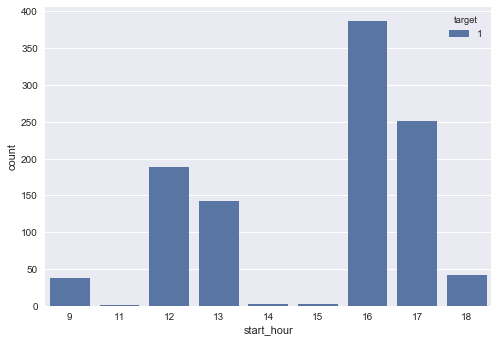

In [64]:
sns.countplot(x="start_hour", hue="target", data=train_df[(train_df['target']==1) & (train_df['year']<2014)])

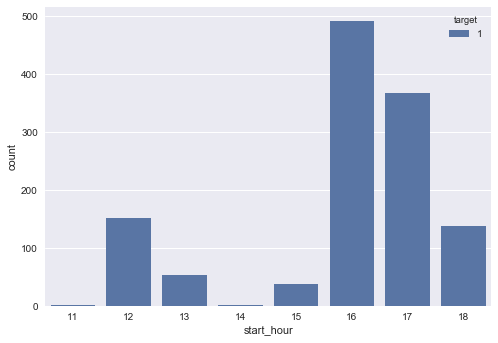

In [66]:
sns.countplot(x="start_hour", hue="target", data=train_df[(train_df['target']==1) & (train_df['year']==2014)])

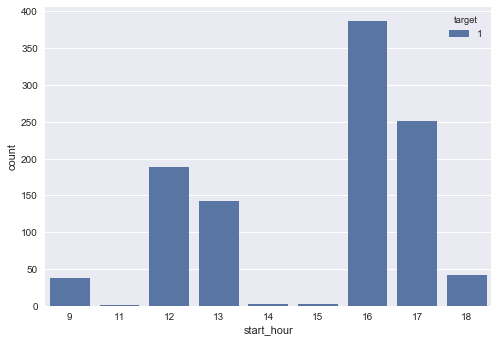

In [71]:
sns.countplot(x="start_hour", hue="target", data=train_df[(train_df['target']==1) & (train_df['year']==2013)])

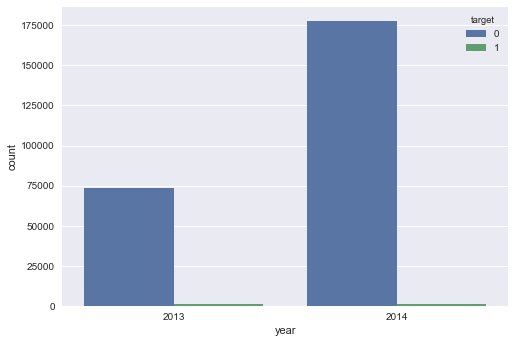

In [72]:
sns.countplot(x="year", hue="target", data=train_df)

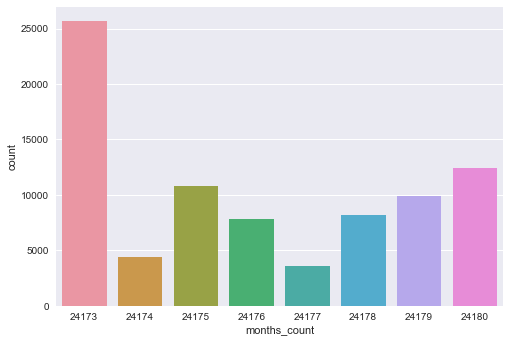

In [75]:
sns.countplot(x="months_count", data=test_df)

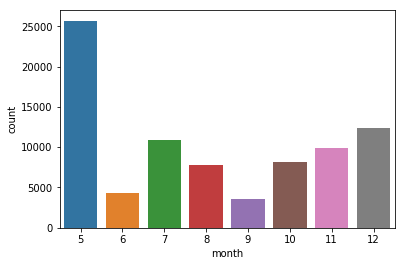

In [20]:
sns.countplot(x="month", data=test_df)

In [80]:
test_df.time1.min()

Timestamp('2014-05-01 17:14:03')

In [88]:
%%time

cv_scores = cross_val_score(logit, X_train_sparse_alicemin2_dayall_september_morningMinutes, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 1min 16s


In [89]:
cv_scores, cv_scores.mean()

(array([ 0.91116986,  0.89905979,  0.93087555,  0.97275411,  0.93509801,
         0.9753213 ,  0.88548503,  0.96274666,  0.92831253,  0.980911  ]),
 0.93817338445561815)

In [90]:
new_feat_train['day6'] = train_df['time1'].apply(lambda ts: 1 if ts.weekday()==6 else 0)
new_feat_test['day6'] = test_df['time1'].apply(lambda ts: 1 if ts.weekday()==6 else 0)

In [91]:
X_train_sparse_alicemin2_dayall_september_day6 = csr_matrix(hstack([X_train_sparse_alicemin2_dayall_september, 
                             new_feat_train['day6'].values.reshape(-1, 1)]
                                                      ))
X_test_sparse_alicemin2_dayall_september_day6  = csr_matrix(hstack([X_test_sparse_alicemin2_dayall_september, 
                              new_feat_test['day6'].values.reshape(-1, 1)]
                                                      ))

In [92]:
%%time

cv_scores = cross_val_score(logit, X_train_sparse_alicemin2_dayall_september_day6, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 25.8 s


In [93]:
cv_scores, cv_scores.mean()

(array([ 0.91645383,  0.896841  ,  0.93593218,  0.97190743,  0.9344251 ,
         0.97398632,  0.88387319,  0.96030011,  0.9329658 ,  0.98004079]),
 0.93867257453680719)

In [94]:
column_sites = ['site'+str(i) for i in range(1, 11)]
train_df[column_sites].to_string(index=False, header=False, na_rep='').split('\n')

['56     55      0      0      0      0      0      0      0      0',
 '   56     55     56     55      0      0      0      0      0      0',
 '  946    946    951    946    946    945    948    784    949    946',
 '  945    948    949    948    945    946    947    945    946    946',
 '  947    950    948    947    950    952    946    951    946    947',
 '  952    947    953    946    947    946    953    955    946    947',
 '  953    947    946    953    955    947    953    946    953   1033',
 '  946    947    954    953    946    954    946    956    957    956',
 '  946    956    946    946    955    954    946    946    946    948',
 '  948    946    948    784     49     53    812    982     52     52',
 '   52     52     52    747    747    747     23    747    568     23',
 '  513   1116    747     23    747    747     29     49     52     21',
 ' 4222   3358   4222   3356   4222   3870     21   3870   3358     21',
 '38667    181     23    181  38667     23    182    1

In [23]:
site=["site%s" % i for i in range(1, 11)]
full_df = pd.concat([train_df.drop('target', axis=1), test_df])
idx=train_df.shape[0]
full_df[site]=full_df[site].fillna(float(0))

In [97]:
full_df['str0']=full_df[site].apply(lambda x: str( " ".join([str(a) for a in x.values if a != 0])), axis=1)

In [26]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pickle
from sklearn.pipeline import Pipeline

In [28]:
y = train_df['target']

In [102]:
pipeline0 = Pipeline([("vectorize", TfidfVectorizer(ngram_range=(1, 3), max_features=100000)), ("tfidf", TfidfTransformer())])
pipeline0.fit(full_df['str0'][:idx].ravel(),y)

X_train0 = pipeline0.transform(full_df['str0'][:idx].ravel())
X_test0 = pipeline0.transform(full_df['str0'][idx:].ravel())

KeyboardInterrupt: 

In [21]:
with open('../../data/site_dic.pkl', "rb") as inp_file:
    site_dic = pickle.load(inp_file)

inv_site_dic = {v: k for k, v in site_dic.items()}
inv_site_dic.update({0: ''})

In [24]:
full_df['str']=full_df[site].apply(lambda x: " ".join( [inv_site_dic[a] for a in x.values if a != 0]), axis=1)
full_df['str']=full_df['str'].apply(lambda x: x.replace('.', ' '))

In [29]:
%%time
pipeline = Pipeline([("vectorize", TfidfVectorizer(ngram_range=(1, 3), max_features=100000)), ("tfidf", TfidfTransformer())])
pipeline.fit(full_df['str'][:idx].ravel(),y)

X_train = pipeline.transform(full_df['str'][:idx].ravel())
X_test = pipeline.transform(full_df['str'][idx:].ravel())

Wall time: 1min 21s


<253561x100000 sparse matrix of type '<type 'numpy.float64'>'
	with 10782248 stored elements in Compressed Sparse Row format>

In [110]:
%%time

cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 4s


In [111]:
cv_scores, cv_scores.mean()

(array([ 0.78775387,  0.65327624,  0.86849087,  0.94255134,  0.83400806,
         0.86883177,  0.90653312,  0.88133506,  0.92016224,  0.92841155]),
 0.85913541173136654)

In [113]:
get_auc_lr_valid(X_train, y_train, ratio=0.7)

0.96117249982623942

In [30]:
X_train_tfidf_alicemin2 = csr_matrix(hstack([X_train, 
                             new_feat_train['alice_tminutes2'].values.reshape(-1, 1)]))
X_test_tfidf_alicemin2  = csr_matrix(hstack([X_test, 
                             new_feat_test['alice_tminutes2'].values.reshape(-1, 1)]))

In [115]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 1min 41s


In [116]:
cv_scores, cv_scores.mean()

(array([ 0.89829926,  0.87260569,  0.9513416 ,  0.94842278,  0.94549648,
         0.95119351,  0.84022791,  0.95368611,  0.97250591,  0.96702898]),
 0.93008082297696004)

In [31]:
from xgboost import XGBRegressor

In [32]:
xgbmodel = XGBRegressor()

In [37]:
time_split = TimeSeriesSplit(n_splits=10)

In [33]:
time_split_3 = TimeSeriesSplit(n_splits=3)

In [36]:
%%time

cv_scores = cross_val_score(xgbmodel, X_train_tfidf_alicemin2, y_train, cv=time_split_3, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

NameError: name 'time_split' is not defined

In [35]:
cv_scores, cv_scores.mean()

(array([ 0.86326632,  0.90499984,  0.92253625]), 0.89693413731495519)

In [38]:
%%time

cv_scores = cross_val_score(xgbmodel, X_train_tfidf_alicemin2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 16min 52s


In [39]:
cv_scores, cv_scores.mean()

(array([ 0.67617086,  0.83829413,  0.92386525,  0.95371999,  0.87800586,
         0.93211837,  0.87948405,  0.93704494,  0.92003284,  0.89931427]),
 0.8838050543977628)

In [117]:
X_train_tfidf_alicemin2_dayall = csr_matrix(hstack([X_train_tfidf_alicemin2, 
                            new_feat_train['day0'].values.reshape(-1, 1),
                            new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day2'].values.reshape(-1, 1),
                            new_feat_train['day3'].values.reshape(-1, 1),
                            new_feat_train['day4'].values.reshape(-1, 1),
                            new_feat_train['day5'].values.reshape(-1, 1),
                            new_feat_train['day6'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_dayall = csr_matrix(hstack([X_test_tfidf_alicemin2, 
                            new_feat_test['day0'].values.reshape(-1, 1),
                            new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day2'].values.reshape(-1, 1),
                            new_feat_test['day3'].values.reshape(-1, 1),
                            new_feat_test['day4'].values.reshape(-1, 1),
                            new_feat_test['day5'].values.reshape(-1, 1),
                            new_feat_test['day6'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [118]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_dayall, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 10s


In [119]:
cv_scores, cv_scores.mean()

(array([ 0.89635226,  0.91144186,  0.91014797,  0.95966958,  0.96374129,
         0.96929532,  0.85957648,  0.96527855,  0.83974961,  0.97863498]),
 0.92538878914689437)

In [120]:
X_train_tfidf_alicemin2_dayall_morningMinutes = csr_matrix(hstack([X_train_tfidf_alicemin2_dayall, 
                             new_feat_train['alice_morning_minutes'].values.reshape(-1, 1)]))
X_test_tfidf_alicemin2_dayall_morningMinutes = csr_matrix(hstack([X_test_tfidf_alicemin2_dayall, 
                             new_feat_test['alice_morning_minutes'].values.reshape(-1, 1)]))

In [121]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_dayall_morningMinutes, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 5s


In [122]:
cv_scores, cv_scores.mean()

(array([ 0.87720677,  0.91227852,  0.91142162,  0.95972602,  0.96470756,
         0.9708378 ,  0.85991751,  0.96699789,  0.84538225,  0.97927064]),
 0.92477465942309356)

In [123]:
X_train_tfidf_alicemin2_day3 = csr_matrix(hstack([X_train_tfidf_alicemin2, 
                            new_feat_train['day0'].values.reshape(-1, 1),
                            new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day4'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_day3 = csr_matrix(hstack([X_test_tfidf_alicemin2, 
                            new_feat_test['day0'].values.reshape(-1, 1),
                            new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day4'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [124]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_day3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 8s


In [125]:
cv_scores, cv_scores.mean()

(array([ 0.85500557,  0.89218816,  0.94724231,  0.94813946,  0.93803453,
         0.96676856,  0.80106909,  0.96456595,  0.96764676,  0.97982519]),
 0.92604855840577116)

In [ ]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

sites = ['site%d' % i for i in range(1, 11)]

full_sites = full_df[sites]

# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

X_train_sparse = full_sites_sparse[:idx_split]
X_test_sparse = full_sites_sparse[idx_split:]

In [126]:
X_train_sparse.shape

(253561, 48371)

In [127]:
X_train_tfidf_alicemin2.shape

(253561, 100001)

In [128]:
X_train_tfidf_alicemin2_ids = hstack((X_train_sparse, X_train_tfidf_alicemin2))

In [129]:
X_train_tfidf_alicemin2_ids.shape

(253561, 148372)

In [130]:
X_test_tfidf_alicemin2_ids = hstack((X_test_sparse, X_test_tfidf_alicemin2))

In [131]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_ids, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 34s


In [132]:
cv_scores, cv_scores.mean()

(array([ 0.92068428,  0.85178662,  0.95073216,  0.95737376,  0.94100836,
         0.95542052,  0.90649692,  0.94334691,  0.97464443,  0.96558644]),
 0.93670803931351421)

In [133]:
X_train_tfidf_alicemin2_ids_day0 = csr_matrix(hstack([X_train_tfidf_alicemin2_ids, 
                            new_feat_train['day0'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_ids_day0 = csr_matrix(hstack([X_test_tfidf_alicemin2_ids, 
                            new_feat_test['day0'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [134]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_ids_day0, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 3min 27s


In [135]:
cv_scores, cv_scores.mean()

(array([ 0.91892893,  0.85369788,  0.95325148,  0.95696778,  0.94581438,
         0.96302465,  0.89478692,  0.95367102,  0.97767895,  0.97348202]),
 0.93913040142136839)

In [136]:
X_train_tfidf_alicemin2_ids_day01 = csr_matrix(hstack([X_train_tfidf_alicemin2_ids_day0, 
                            new_feat_train['day1'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_ids_day01 = csr_matrix(hstack([X_test_tfidf_alicemin2_ids_day0, 
                            new_feat_test['day1'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [139]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_ids_day01, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 3min 48s


In [140]:
cv_scores, cv_scores.mean()

(array([ 0.91880648,  0.84971002,  0.95329867,  0.95622639,  0.94492636,
         0.96223507,  0.89253163,  0.95572812,  0.97773912,  0.9771424 ]),
 0.93883442599372713)

In [142]:
logit.fit(X_train_tfidf_alicemin2_ids_day0, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [143]:
test_pred = logit.predict_proba(X_test_tfidf_alicemin2_ids_day0)[:, 1]
write_to_submission_file(test_pred, 'X_test_tfidf_alicemin2_ids_day0.csv')

In [144]:
X_train_tfidf_alicemin2_ids_dayall = csr_matrix(hstack([X_train_tfidf_alicemin2_ids_day0, 
                            new_feat_train['day1'].values.reshape(-1, 1),
                            new_feat_train['day2'].values.reshape(-1, 1),
                            new_feat_train['day3'].values.reshape(-1, 1),
                            new_feat_train['day4'].values.reshape(-1, 1),
                            new_feat_train['day5'].values.reshape(-1, 1),
                            new_feat_train['day6'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_ids_dayall = csr_matrix(hstack([X_test_tfidf_alicemin2_ids_day0, 
                            new_feat_test['day1'].values.reshape(-1, 1),
                            new_feat_test['day2'].values.reshape(-1, 1),
                            new_feat_test['day3'].values.reshape(-1, 1),
                            new_feat_test['day4'].values.reshape(-1, 1),
                            new_feat_test['day5'].values.reshape(-1, 1),
                            new_feat_test['day6'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [146]:
X_train_tfidf_alicemin2_ids_dayall_mm_September = csr_matrix(hstack([X_train_tfidf_alicemin2_ids_dayall, 
                            new_feat_train['alice_morning_minutes'].values.reshape(-1, 1),
                            new_feat_train['september'].values.reshape(-1, 1)
                                                                                  ]
                                                      ))
X_test_tfidf_alicemin2_ids_dayall_mm_September = csr_matrix(hstack([X_test_tfidf_alicemin2_ids_dayall, 
                            new_feat_test['alice_morning_minutes'].values.reshape(-1, 1),
                            new_feat_test['september'].values.reshape(-1, 1)
                                                                                 ]
                                                      ))

In [147]:
%%time

cv_scores = cross_val_score(logit, X_train_tfidf_alicemin2_ids_dayall_mm_September, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 2min 15s


In [148]:
cv_scores, cv_scores.mean()

(array([ 0.90703669,  0.89730642,  0.93967556,  0.97210282,  0.93604137,
         0.97586845,  0.88957095,  0.96522935,  0.93560306,  0.98140853]),
 0.93998431838193852)

In [149]:
logit.fit(X_train_tfidf_alicemin2_ids_dayall_mm_September, y_train)
test_pred = logit.predict_proba(X_test_tfidf_alicemin2_ids_dayall_mm_September)[:, 1]
write_to_submission_file(test_pred, 'X_test_tfidf_alicemin2_ids_dayall_mm_September.csv')

In [152]:
from catboost import Pool, CatBoostClassifier

In [154]:
cat = CatBoostClassifier(random_state=17)


In [159]:
from xgboost import XGBRegressor

ImportError: No module named xgboost

In [155]:
time_split_3 = TimeSeriesSplit(n_splits=3)

In [156]:
%%time

cv_scores = cross_val_score(cat, X_train_tfidf_alicemin2_ids_dayall_mm_September, y_train, cv=time_split_3, 
                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster

JoblibCatboostError: JoblibCatboostError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Anaconda2\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = r'C:\Anaconda2\lib\site-packages\ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
C:\Anaconda2\lib\runpy.py in _run_code(code=<code object <module> at 0000000004749CB0, file ...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Anaconda2\lib\site-packages\ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from 'C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname=r'C:\Anaconda2\lib\site-packages\ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0000000004749CB0, file ...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Anaconda2\lib\site-packages\ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from 'C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
C:\Anaconda2\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Anaconda2\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Anaconda2\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 22, 6, 42, 47, 863000, tzinfo=tzutc()), u'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', u'msg_type': u'execute_request', u'session': u'B79998034CA04350A3C2C7605EF52F93', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', 'msg_type': u'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['B79998034CA04350A3C2C7605EF52F93']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 22, 6, 42, 47, 863000, tzinfo=tzutc()), u'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', u'msg_type': u'execute_request', u'session': u'B79998034CA04350A3C2C7605EF52F93', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', 'msg_type': u'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['B79998034CA04350A3C2C7605EF52F93'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 4, 22, 6, 42, 47, 863000, tzinfo=tzutc()), u'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', u'msg_type': u'execute_request', u'session': u'B79998034CA04350A3C2C7605EF52F93', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'26D25904CA9D40D086BB07E192AE7CB8', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Anaconda2\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"%%time\n\ncv_scores = cross_val_score(cat, X_t...th n_jobs > 1, and locally this runs much faster", store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-156-855cb4505899>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 46e86940, execution_c..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0000000019441E30, file "<ipython-input-156-855cb4505899>", line 1>
        result = <ExecutionResult object at 46e86940, execution_c..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0000000019441E30, file "<ipython-input-156-855cb4505899>", line 1>, result=<ExecutionResult object at 46e86940, execution_c..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0000000019441E30, file "<ipython-input-156-855cb4505899>", line 1>
        self.user_global_ns = {'CatBoostClassifier': <class 'catboost.core.CatBoostClassifier'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Counter': <class 'collections.Counter'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u"import pickle\nimport numpy as np\nimport pand...tlib import pyplot as plt\nimport seaborn as sns", u"# \u0437\u0430\u0433\u0440\u0443\u0437\u0438\u...438\ntrain_df = train_df.sort_values(by='time1')", u'# \u043f\u0440\u0438\u0432\u0435\u0434\u0435\u... sites_dict_df.shape[0])\n\nsites_dict_df.head()', u"# \u043d\u0430\u0448\u0430 \u0446\u0435\u043b\...]\nX_test_sparse = full_sites_sparse[idx_split:]", u'from sklearn.model_selection import train_test_split, GridSearchCV', u"def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9,... \n    return roc_auc_score(y_valid, valid_pred)", u'get_auc_lr_valid(X_train_sparse, y_train, ratio = 0.9)', u'# \u0444\u0443\u043d\u043a\u0446\u0438\u044f \...ted_df.to_csv(out_file, index_label=index_label)', u'new_feat_train = pd.DataFrame(index=train_df.i...ew_feat_test = pd.DataFrame(index=test_df.index)', u"new_feat_train['alice_tminutes'] = train_df['t... >= 954 and ts.hour*60+ts.minute <=1100) else 0)", u"X_train_sparse_alicemin = csr_matrix(hstack([X..._test['alice_tminutes'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u"new_feat_train['alice_tminutes2'] = train_df['...e >= 548 and ts.hour*60+ts.minute <=559) else 0)", u"X_train_sparse_alicemin2 = csr_matrix(hstack([...test['alice_tminutes2'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u'get_auc_lr_valid(X_train_sparse_alicemin2, y_train)', u"new_feat_train['day0'] = train_df['time1'].app...'].apply(lambda ts: 1 if ts.weekday()==5 else 0)", u"X_train_sparse_alicemin2_dayall = csr_matrix(h...                                              ))", u'get_auc_lr_valid(X_train_sparse_alicemin2_dayall, y_train)', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {3:                                                 ...                         9zouxfza1h.s.ad6media.fr, 7: 0.96433761440091936, 12: 0.98650035989731588, 16: 0.98708576028395223, 19: 0.9910118176175845, 20: 0.9910118176175845, 23: 0.99119403526923877, 24: 0.99119403526923877, 32: 0.99287326517974273, 33:             site1               time1  site2    ...:22       0        24157  

[5 rows x 22 columns], ...}, ...}
        self.user_ns = {'CatBoostClassifier': <class 'catboost.core.CatBoostClassifier'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Counter': <class 'collections.Counter'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u"import pickle\nimport numpy as np\nimport pand...tlib import pyplot as plt\nimport seaborn as sns", u"# \u0437\u0430\u0433\u0440\u0443\u0437\u0438\u...438\ntrain_df = train_df.sort_values(by='time1')", u'# \u043f\u0440\u0438\u0432\u0435\u0434\u0435\u... sites_dict_df.shape[0])\n\nsites_dict_df.head()', u"# \u043d\u0430\u0448\u0430 \u0446\u0435\u043b\...]\nX_test_sparse = full_sites_sparse[idx_split:]", u'from sklearn.model_selection import train_test_split, GridSearchCV', u"def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9,... \n    return roc_auc_score(y_valid, valid_pred)", u'get_auc_lr_valid(X_train_sparse, y_train, ratio = 0.9)', u'# \u0444\u0443\u043d\u043a\u0446\u0438\u044f \...ted_df.to_csv(out_file, index_label=index_label)', u'new_feat_train = pd.DataFrame(index=train_df.i...ew_feat_test = pd.DataFrame(index=test_df.index)', u"new_feat_train['alice_tminutes'] = train_df['t... >= 954 and ts.hour*60+ts.minute <=1100) else 0)", u"X_train_sparse_alicemin = csr_matrix(hstack([X..._test['alice_tminutes'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u"new_feat_train['alice_tminutes2'] = train_df['...e >= 548 and ts.hour*60+ts.minute <=559) else 0)", u"X_train_sparse_alicemin2 = csr_matrix(hstack([...test['alice_tminutes2'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u'get_auc_lr_valid(X_train_sparse_alicemin2, y_train)', u"new_feat_train['day0'] = train_df['time1'].app...'].apply(lambda ts: 1 if ts.weekday()==5 else 0)", u"X_train_sparse_alicemin2_dayall = csr_matrix(h...                                              ))", u'get_auc_lr_valid(X_train_sparse_alicemin2_dayall, y_train)', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {3:                                                 ...                         9zouxfza1h.s.ad6media.fr, 7: 0.96433761440091936, 12: 0.98650035989731588, 16: 0.98708576028395223, 19: 0.9910118176175845, 20: 0.9910118176175845, 23: 0.99119403526923877, 24: 0.99119403526923877, 32: 0.99287326517974273, 33:             site1               time1  site2    ...:22       0        24157  

[5 rows x 22 columns], ...}, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
C:\Anaconda2\Scripts\<ipython-input-156-855cb4505899> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 get_ipython().run_cell_magic(u'time', u'', u"\ncv_scores = cross_val_score(cat, X_train_tfidf_alicemin2_ids_dayall_mm_September, y_train, cv=time_split_3, \n                            scoring='roc_auc', n_jobs=2) # hangs with n_jobs > 1, and locally this runs much faster")
      7 
      8 
      9 
     10 

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name=u'time', line=u'', cell=u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster")
   2110             # This will need to be updated if the internal calling logic gets
   2111             # refactored, or else we'll be expanding the wrong variables.
   2112             stack_depth = 2
   2113             magic_arg_s = self.var_expand(line, stack_depth)
   2114             with self.builtin_trap:
-> 2115                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = u''
        cell = u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster"
   2116             return result
   2117 
   2118     def find_line_magic(self, magic_name):
   2119         """Find and return a line magic by name.

...........................................................................
C:\Anaconda2\Scripts\<decorator-gen-60> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line=u'', cell=u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster", local_ns=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\magic.py in <lambda>(f=<function time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, u'', u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster", None), **k={})
    183     validate_type(magic_kind)
    184 
    185     # This is a closure to capture the magic_kind.  We could also use a class,
    186     # but it's overkill for just that one bit of state.
    187     def magic_deco(arg):
--> 188         call = lambda f, *a, **k: f(*a, **k)
        f = <function time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, u'', u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster", None)
        k = {}
    189 
    190         if callable(arg):
    191             # "Naked" decorator call (just @foo, no args)
    192             func = arg

...........................................................................
C:\Anaconda2\lib\site-packages\IPython\core\magics\execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line=u'', cell=u"\ncv_scores = cross_val_score(cat, X_train_tfi...th n_jobs > 1, and locally this runs much faster", local_ns=None)
   1180             st = clock2()
   1181             out = eval(code, glob, local_ns)
   1182             end = clock2()
   1183         else:
   1184             st = clock2()
-> 1185             exec(code, glob, local_ns)
        code = <code object <module> at 0000000046E660B0, file "<timed exec>", line 2>
        glob = {'CatBoostClassifier': <class 'catboost.core.CatBoostClassifier'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'Counter': <class 'collections.Counter'>, 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', u"import pickle\nimport numpy as np\nimport pand...tlib import pyplot as plt\nimport seaborn as sns", u"# \u0437\u0430\u0433\u0440\u0443\u0437\u0438\u...438\ntrain_df = train_df.sort_values(by='time1')", u'# \u043f\u0440\u0438\u0432\u0435\u0434\u0435\u... sites_dict_df.shape[0])\n\nsites_dict_df.head()', u"# \u043d\u0430\u0448\u0430 \u0446\u0435\u043b\...]\nX_test_sparse = full_sites_sparse[idx_split:]", u'from sklearn.model_selection import train_test_split, GridSearchCV', u"def get_auc_lr_valid(X, y, C=1.0, ratio = 0.9,... \n    return roc_auc_score(y_valid, valid_pred)", u'get_auc_lr_valid(X_train_sparse, y_train, ratio = 0.9)', u'# \u0444\u0443\u043d\u043a\u0446\u0438\u044f \...ted_df.to_csv(out_file, index_label=index_label)', u'new_feat_train = pd.DataFrame(index=train_df.i...ew_feat_test = pd.DataFrame(index=test_df.index)', u"new_feat_train['alice_tminutes'] = train_df['t... >= 954 and ts.hour*60+ts.minute <=1100) else 0)", u"X_train_sparse_alicemin = csr_matrix(hstack([X..._test['alice_tminutes'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u"new_feat_train['alice_tminutes2'] = train_df['...e >= 548 and ts.hour*60+ts.minute <=559) else 0)", u"X_train_sparse_alicemin2 = csr_matrix(hstack([...test['alice_tminutes2'].values.reshape(-1, 1)]))", u'get_auc_lr_valid(X_train_sparse_alicemin, y_train)', u'get_auc_lr_valid(X_train_sparse_alicemin2, y_train)', u"new_feat_train['day0'] = train_df['time1'].app...'].apply(lambda ts: 1 if ts.weekday()==5 else 0)", u"X_train_sparse_alicemin2_dayall = csr_matrix(h...                                              ))", u'get_auc_lr_valid(X_train_sparse_alicemin2_dayall, y_train)', ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'OneHotEncoder': <class 'sklearn.preprocessing.data.OneHotEncoder'>, 'Out': {3:                                                 ...                         9zouxfza1h.s.ad6media.fr, 7: 0.96433761440091936, 12: 0.98650035989731588, 16: 0.98708576028395223, 19: 0.9910118176175845, 20: 0.9910118176175845, 23: 0.99119403526923877, 24: 0.99119403526923877, 32: 0.99287326517974273, 33:             site1               time1  site2    ...:22       0        24157  

[5 rows x 22 columns], ...}, ...}
        local_ns = None
   1186             end = clock2()
   1187             out = None
   1188         wall_end = wtime()
   1189         # Compute actual times and report

...........................................................................
C:\Anaconda2\Scripts\<timed exec> in <module>()
      1 
      2 
----> 3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py in cross_val_score(estimator=<catboost.core.CatBoostClassifier object>, X=<253561x148381 sparse matrix of type '<type 'num... stored elements in Compressed Sparse Row format>, y=session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, groups=None, scoring='roc_auc', cv=TimeSeriesSplit(n_splits=3), n_jobs=2, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    135     parallel = Parallel(n_jobs=n_jobs, verbose=verbose,
    136                         pre_dispatch=pre_dispatch)
    137     scores = parallel(delayed(_fit_and_score)(clone(estimator), X, y, scorer,
    138                                               train, test, verbose, None,
    139                                               fit_params)
--> 140                       for train, test in cv_iter)
        cv_iter = [(array([    0,     1,     2, ..., 63388, 63389, 63390]), array([ 63391,  63392,  63393, ..., 126778, 126779, 126780])), (array([     0,      1,      2, ..., 126778, 126779, 126780]), array([126781, 126782, 126783, ..., 190168, 190169, 190170])), (array([     0,      1,      2, ..., 190168, 190169, 190170]), array([190171, 190172, 190173, ..., 253558, 253559, 253560]))]
    141     return np.array(scores)[:, 0]
    142 
    143 
    144 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
CatboostError                                      Sun Apr 22 11:43:49 2018
PID: 17532                           Python 2.7.13: C:\Anaconda2\python.exe
...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (<catboost.core.CatBoostClassifier object>, <253561x148381 sparse matrix of type '<type 'num... stored elements in Compressed Sparse Row format>, session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, make_scorer(roc_auc_score, needs_threshold=True), array([    0,     1,     2, ..., 63388, 63389, 63390]), array([ 63391,  63392,  63393, ..., 126778, 126779, 126780]), 0, None, None)
        kwargs = {}
        self.items = [(<function _fit_and_score>, (<catboost.core.CatBoostClassifier object>, <253561x148381 sparse matrix of type '<type 'num... stored elements in Compressed Sparse Row format>, session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, make_scorer(roc_auc_score, needs_threshold=True), array([    0,     1,     2, ..., 63388, 63389, 63390]), array([ 63391,  63392,  63393, ..., 126778, 126779, 126780]), 0, None, None), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=<catboost.core.CatBoostClassifier object>, X=<253561x148381 sparse matrix of type '<type 'num... stored elements in Compressed Sparse Row format>, y=session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, scorer=make_scorer(roc_auc_score, needs_threshold=True), train=array([    0,     1,     2, ..., 63388, 63389, 63390]), test=array([ 63391,  63392,  63393, ..., 126778, 126779, 126780]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method CatBoostClassifier.fit of <catboost.core.CatBoostClassifier object>>
        X_train = <63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>
        y_train = session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
C:\Anaconda2\lib\site-packages\catboost\core.py in fit(self=<catboost.core.CatBoostClassifier object>, X=<63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>, y=session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64, cat_features=None, sample_weight=None, baseline=None, use_best_model=None, eval_set=None, verbose=None, logging_level=None, plot=False, column_description=None, verbose_eval=None)
   1671 
   1672         Returns
   1673         -------
   1674         model : CatBoost
   1675         """
-> 1676         self._fit(X, y, cat_features, None, sample_weight, None, None, None, baseline, use_best_model, eval_set, verbose, logging_level, plot, column_description, verbose_eval)
        self._fit = <bound method CatBoostClassifier._fit of <catboost.core.CatBoostClassifier object>>
        X = <63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>
        y = session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64
        cat_features = None
        sample_weight = None
        baseline = None
        use_best_model = None
        eval_set = None
        verbose = None
        logging_level = None
        plot = False
        column_description = None
        verbose_eval = None
   1677         return self
   1678 
   1679     def predict(self, data, prediction_type='Class', ntree_start=0, ntree_end=0, thread_count=-1, verbose=None):
   1680         """

...........................................................................
C:\Anaconda2\lib\site-packages\catboost\core.py in _fit(self=<catboost.core.CatBoostClassifier object>, X=<63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>, y=session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64, cat_features=None, pairs=None, sample_weight=None, group_id=None, subgroup_id=None, pairs_weight=None, baseline=None, use_best_model=None, eval_set=None, verbose=None, logging_level=None, plot=False, column_description=None, verbose_eval=None)
    747         if logging_level is not None:
    748             params['logging_level'] = logging_level
    749         if use_best_model is not None:
    750             params['use_best_model'] = use_best_model
    751 
--> 752         train_pool = _build_train_pool(X, y, cat_features, pairs, sample_weight, group_id, subgroup_id, pairs_weight, baseline, column_description)
        train_pool = undefined
        X = <63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>
        y = session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64
        cat_features = None
        pairs = None
        sample_weight = None
        group_id = None
        subgroup_id = None
        pairs_weight = None
        baseline = None
        column_description = None
    753         if train_pool.is_empty_:
    754             raise CatboostError("X is empty.")
    755 
    756         if column_description is not None and not isinstance(X, STRING_TYPES) and not isinstance(eval_set, STRING_TYPES):

...........................................................................
C:\Anaconda2\lib\site-packages\catboost\core.py in _build_train_pool(X=<63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>, y=session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64, cat_features=None, pairs=None, sample_weight=None, group_id=None, subgroup_id=None, pairs_weight=None, baseline=None, column_description=None)
    549             train_pool = Pool(data=X, pairs=pairs, column_description=column_description)
    550     else:
    551         if y is None:
    552             raise CatboostError("y has not initialized in fit(): X is not catboost.Pool object, y must be not None in fit().")
    553         train_pool = Pool(X, y, cat_features=cat_features, pairs=pairs, weight=sample_weight, group_id=group_id,
--> 554                           subgroup_id=subgroup_id, pairs_weight=pairs_weight, baseline=baseline)
        subgroup_id = None
        pairs_weight = None
        baseline = None
    555     return train_pool
    556 
    557 
    558 def _clear_training_files(train_dir):

...........................................................................
C:\Anaconda2\lib\site-packages\catboost\core.py in __init__(self=<catboost.core.Pool object>, data=<63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>, label=session_id
21669     0
54843     0
77292     0
1...24    0
Name: target, Length: 63391, dtype: int64, cat_features=None, column_description=None, pairs=None, delimiter='\t', has_header=False, weight=None, group_id=None, subgroup_id=None, pairs_weight=None, baseline=None, feature_names=None, thread_count=-1)
    209             Thread count to read data from file.
    210             Use only with reading data from file.
    211             If -1, then the number of threads is set to the number of cores.
    212         """
    213         if data is not None:
--> 214             self._check_data_type(data)
        self._check_data_type = <bound method Pool._check_data_type of <catboost.core.Pool object>>
        data = <63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>
    215             self._check_data_empty(data)
    216             if pairs is not None and isinstance(data, STRING_TYPES) != isinstance(pairs, STRING_TYPES):
    217                 raise CatboostError("Data and pairs should be the same types.")
    218             if isinstance(data, STRING_TYPES):

...........................................................................
C:\Anaconda2\lib\site-packages\catboost\core.py in _check_data_type(self=<catboost.core.Pool object>, data=<63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>)
    285     def _check_data_type(self, data):
    286         """
    287         Check type of data.
    288         """
    289         if not isinstance(data, (STRING_TYPES, ARRAY_TYPES)):
--> 290             raise CatboostError("Invalid data type={}: data must be list(), np.ndarray(), DataFrame(), Series() or filename str().".format(type(data)))
        data = <63391x148381 sparse matrix of type '<type 'nump... stored elements in Compressed Sparse Row format>
    291 
    292     def _check_data_empty(self, data):
    293         """
    294         Check data is not empty.

CatboostError: Invalid data type=<class 'scipy.sparse.csr.csr_matrix'>: data must be list(), np.ndarray(), DataFrame(), Series() or filename str().
___________________________________________________________________________

In [ ]:
cv_scores, cv_scores.mean()

In [158]:
!pip install xgboost

No files/directories in c:\temp\pip-build-7p3d2d\xgboost\pip-egg-info (from PKG-INFO)
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [160]:
!pip install --upgrade pip

  Found existing installation: pip 9.0.3
    Uninstalling pip-9.0.3:
      Successfully uninstalled pip-9.0.3


Exception:
Traceback (most recent call last):
  File "c:\anaconda2\lib\site-packages\pip\basecommand.py", line 215, in main
  File "c:\anaconda2\lib\site-packages\pip\commands\install.py", line 342, in run
  File "c:\anaconda2\lib\site-packages\pip\req\req_set.py", line 795, in install
  File "c:\anaconda2\lib\site-packages\pip\req\req_install.py", line 767, in commit_uninstall
  File "c:\anaconda2\lib\site-packages\pip\req\req_uninstall.py", line 142, in commit
  File "c:\anaconda2\lib\site-packages\pip\_vendor\retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "c:\anaconda2\lib\site-packages\pip\_vendor\retrying.py", line 212, in call
    raise attempt.get()
  File "c:\anaconda2\lib\site-packages\pip\_vendor\retrying.py", line 247, in get
    six.reraise(self.value[0], self.value[1], self.value[2])
  File "c:\anaconda2\lib\site-packages\pip\_vendor\retrying.py", line 200, in call
    attempt = Attempt(fn(*args, **kwargs), attempt_number

In [151]:
!pip install catboost

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
